# Biweekly Report 5

**Spencer Shortt**

In a previous lecture, we introduced how reinforcement learning will help with AutoML. Well, I accidently got Reinforcement learning confused with Recurrent Neural Networks and did a lot of research on RNN's. So this week's report is using LSTM's to try to predict stock data! It's still good practice developing deep learning models and now we get to see it in the context of time series data.

For this week's report, we follow the work done in https://medium.com/@kumarpal.nagar/stock-price-prediction-using-artificial-recurrent-neural-network-part-1-5955f93b6734 but with a different dataset, the ADP stock data taken from Kaggle. Actually, I got the the model to work well for the ADP data but I wasn't able to recreate it for some reason. So I attach a picture at the bottom, while my actual work is on AAPL data from the past year. We also refer to the following references for how gradients are computed and how RNN's work in general: 

https://towardsdatascience.com/recurrent-neural-networks-rnns-3f06d7653a85

https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/

https://willwolf.io/2016/10/18/recurrent-neural-network-gradients-and-lessons-learned-therein/


First we import our libraries:

In [ ]:
import numpy as np
import pandas as pd
#•matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

Next we import our data. I'm using Google Colab so I have to do some drive mounting. Then we try to clean it a bit:

In [ ]:
from google.colab import files

from google.colab import drive
drive.mount('/content/drive')

!cp drive/MyDrive/ADP.csv .
!cp drive/MyDrive/AAPL.csv .


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#df = pd.read_csv('ADP.csv')
df = pd.read_csv('AAPL.csv')


df = df.dropna()



In [ ]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-10-27,149.360001,149.729996,148.490005,148.850006,148.020569,56094900
1,2021-10-28,149.820007,153.169998,149.720001,152.570007,151.719833,100077900
2,2021-10-29,147.220001,149.940002,146.410004,149.800003,148.965271,124953200
3,2021-11-01,148.990005,149.699997,147.800003,148.960007,148.129974,74588300
4,2021-11-02,148.660004,151.570007,148.649994,150.020004,149.184052,69122000
...,...,...,...,...,...,...,...
248,2022-10-21,142.869995,147.850006,142.649994,147.270004,147.270004,86464700
249,2022-10-24,147.190002,150.229996,146.000000,149.449997,149.449997,75981900
250,2022-10-25,150.089996,152.490005,149.360001,152.339996,152.339996,74732300
251,2022-10-26,150.960007,151.990005,148.039993,149.350006,149.350006,88194300


From here we want to only worry about predicting the daily Low value of a stock:

In [ ]:
df1 = df.reset_index()['Low']
df1.dropna()

df1

0      148.490005
1      149.720001
2      146.410004
3      147.800003
4      148.649994
          ...    
248    142.649994
249    146.000000
250    149.360001
251    148.039993
252    145.540802
Name: Low, Length: 253, dtype: float64

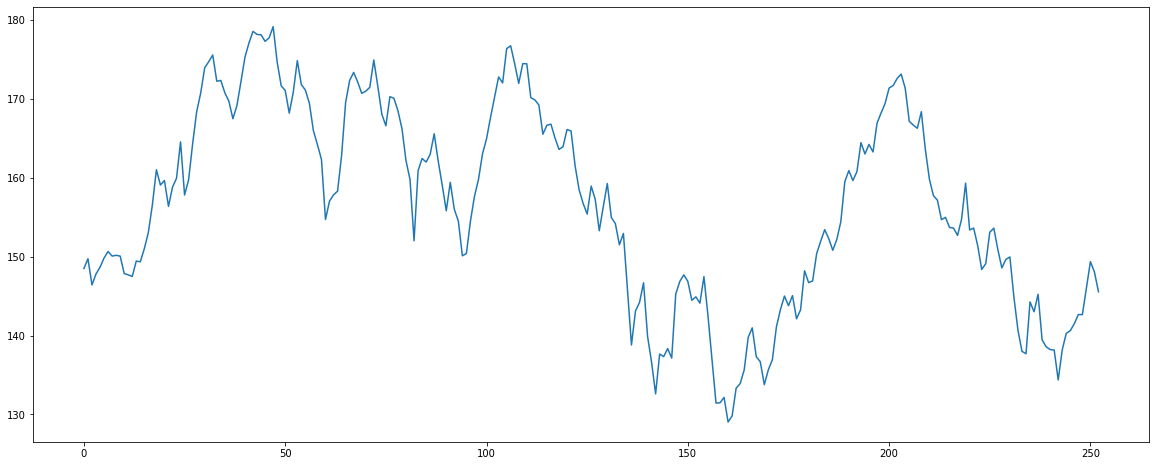

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(df1)

After this we do some min max scaling to normalize our data:

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1) .reshape(-1,1))
df1.shape

(253, 1)

In [ ]:
train_data, test_data = df1[0:int(.8*len(df)) ,:], df1[int(.8*len(df)):len(df1), :]
train_data.shape, test_data.shape

((202, 1), (51, 1))

Now we need to transform our data into an input type that is appropriate for our RNN model. This is dependent on how much of the previous time series data we want to unwrap for each input:

In [ ]:
def create_dataset(dataset, time_step=1):
  dataX, dataY = [],[]
  for i in range(len(dataset) -time_step-1):
    a = dataset[i: (i+time_step), 0]
    dataX.append(a)
    dataY.append(dataset[i + time_step, 0])
  return np.array(dataX), np.array(dataY)

In [ ]:
step_size = 30
X_train, y_train = create_dataset(train_data, step_size)
X_test, y_test = create_dataset(test_data, step_size)

X_train.shape


(171, 30)

In [ ]:
X_train =X_train.reshape(X_train.shape[0],X_train. shape[1] , 1 )
X_test = X_test.reshape (X_test.shape[0], X_test. shape[1], 1)
X_train.shape

(171, 30, 1)

Now we create our neural network model using tensorflow:

In [ ]:
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape =(X_train.shape[1],1) ))
model.add(Dropout(0.1))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])





In [ ]:

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 30, 50)            10400     
                                                                 
 dropout_4 (Dropout)         (None, 30, 50)            0         
                                                                 
 lstm_7 (LSTM)               (None, 30, 50)            20200     
                                                                 
 dropout_5 (Dropout)         (None, 30, 50)            0         
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trai

Next we train our model:

In [ ]:
model.fit(X_train , y_train, epochs=20 , batch_size=64, shuffle=False)

Epoch 1/20
3/3 [==============================] - 0s 105ms/step - loss: 0.0387 - accuracy: 0.0117
Epoch 2/20
3/3 [==============================] - 0s 104ms/step - loss: 0.0503 - accuracy: 0.0117
Epoch 3/20
3/3 [==============================] - 0s 114ms/step - loss: 0.0504 - accuracy: 0.0117
Epoch 4/20
3/3 [==============================] - 0s 45ms/step - loss: 0.0407 - accuracy: 0.0117
Epoch 5/20
3/3 [==============================] - 0s 46ms/step - loss: 0.0366 - accuracy: 0.0117
Epoch 6/20
3/3 [==============================] - 0s 48ms/step - loss: 0.0391 - accuracy: 0.0117
Epoch 7/20
3/3 [==============================] - 0s 44ms/step - loss: 0.0359 - accuracy: 0.0117
Epoch 8/20
3/3 [==============================] - 0s 44ms/step - loss: 0.0331 - accuracy: 0.0117
Epoch 9/20
3/3 [==============================] - 0s 52ms/step - loss: 0.0328 - accuracy: 0.0117
Epoch 10/20
3/3 [==============================] - 0s 51ms/step - loss: 0.0349 - accuracy: 0.0117
Epoch 11/20
3/3 [=========

In [ ]:
test_predict = model.predict(X_test)

print (f'MSE {mean_squared_error(y_test, test_predict)}')
print (f'R2 {r2_score(y_test, test_predict)} ')

1/1 [==============================] - 0s 20ms/step
MSE 0.023748722362829888
R2 -3.3014409144574266 


Next we want to recreate the plot to see how our model performs:

In [ ]:
test_predict=scaler.inverse_transform(test_predict)
train_predict=model.predict(X_train)
train_predict=scaler.inverse_transform(train_predict)

6/6 [==============================] - 0s 9ms/step


In [ ]:
test_predict.shape

(20, 1)

In [ ]:
look_back = 30#step_size
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict


testPredictPlot = np.empty_like(df1)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1,:] = test_predict



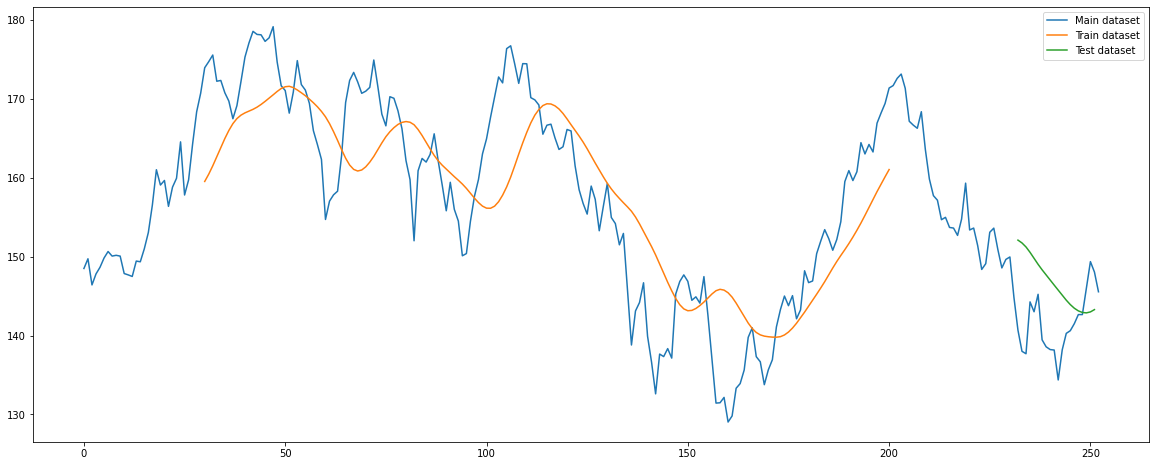

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(scaler.inverse_transform(df1), label='Main dataset')
plt.plot(trainPredictPlot, label='Train dataset')
plt.plot(testPredictPlot, label='Test dataset')
plt.legend()

As you can see, the model performs alright considering our data set is pretty small, but the break between lines is a new problem I have to fix. I had pretty good success with the ADP stock data but I'm having technical difficulties.

In conclusion, I didn't get to explore Reinforcement learning like I intended, but I did look at LSTM's and RNN's in general, and got more practice making deep learning models.